In [1]:
%matplotlib inline

from mpmath import pi
from mpmath import sqrt
from math import exp

import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import interp1d
from scipy.integrate import quad

'''
astro packages:
'''
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value
from astropy import units as u

In [2]:
#### unpack FRB-cat1 data published by CHIME ####

snr, dm, low_ft_95, up_ft_95, flux, flux_err, fluence, fluence_err, = np.loadtxt(
    './data/chimefrbcat1.csv', skiprows=1, usecols=(17, 18, 21, 22, 31, 32, 34, 35), delimiter=',', unpack=True)

tns = np.loadtxt('./data/chimefrbcat1.csv', dtype='str', skiprows=1, usecols=(0), delimiter=',')
fluence_notes = np.loadtxt('./data/chimefrbcat1.csv', dtype='str', skiprows=1, usecols=36, delimiter=',')

## note: low_ft_95, up_ft_95, flux, flux_err, fluence_err never used
##       tns, fluence_notes are never used
## only snr, dm, fluence are relevant

#### define minimmum fluence for each event #####

MIN_SNR = 12 # approx. threshold, according to CHIME's cat1 paper
min_fluence = fluence * (MIN_SNR / snr) # scale reported fluence 'snr' by SNR ratio

In [3]:
#### DM conversion to redshift ####

K_MACQUART = 700/0.7 # approx. value of the proportionality constant linking redshift and dispersion
ISM = 30 # ansatz of interstellar medium's contribution to disperson, in pc cm-3
HALO = 50 # ansatz of MW's halo contribution to disperson, in pc cm-3

'''
function 'dm_ex' returns the extragalactic contribution to an FRB's total dispersion measure (dm_tot)
provided approx. values of the dispersion due to the interstellar medium (ISM) and the MW's halo (HALO)
'''
def dm_ex(dm_tot, dm_ism=ISM, dm_halo=HALO):
    return dm_tot - (dm_ism + dm_halo)

'''
function 'get_z' takes a dispersion measure and ansatz of the Macquart relation 
and returns corresponding redshift
'''
def get_z(dm, k=K_MACQUART):
    y = dm_ex(dm)
    arr = np.roots([1, (1 - y/k), ((1/k)*(50 - y))]) # apply Macquart relation
    zeroes = np.argwhere(arr > 0).flatten()
    if len(zeroes) > 0:
        return arr[zeroes].item()
    else:
        return 0

#### construct array of approximate redshift values for all cat1 FRBs ####

rs = []

for i, dm_i in enumerate(dm):
    rs.append(get_z(dm_i))
    
rs = np.array(rs)

#### fluence conversion to luminosity ####

'''
function 'd_L' returns luminosity distance in cm which corresponds to a given redshift z
'''
def d_L(z):
    return cosmo.luminosity_distance(z).to(u.cm).value 

'''
function 'get_lum' returns luminosity in erg / s which corresponds to a fluence reported at
redshift z. Note: the kwarg 'evo' is an ansatz for a model which allows for luminosity evolution.
'''
def get_lum(z, fluence, evo=1):
    # returns luminosity in erg/s visible at redshift z due to fluence flu
    lum = (4 * pi * d_L(z)**2 / (1 + z) * fluence)
    return lum / evo


#### construct arrays for FRB luminosities and minimum luminosities detectable by CHIME ####

lum = []
min_lum = []

for i, z, in enumerate(rs):
    lum.append(get_lum(z, fluence[i]))
    min_lum.append(get_lum(z, min_fluence[i]))

lum = np.array(lum, dtype=float)
min_lum = np.array(min_lum, dtype=float)

In [18]:
lum #luminsoities of 1e58 erg/s. That's more than 10^10 times more than a supernova! this can't be the right units.

array([3.91526456e+57, 1.70607023e+57, 0.00000000e+00, 1.13821260e+56,
       4.43605773e+58, 6.28546822e+57, 8.45633967e+57, 4.46256944e+56,
       3.20097982e+55, 6.32807646e+57, 3.31890583e+56, 3.31890583e+56,
       2.83608504e+55, 6.52878144e+58, 8.61522166e+56, 5.22249002e+56,
       2.94459321e+58, 2.40404810e+58, 4.76283595e+57, 2.37171533e+57,
       1.09846731e+57, 1.20276672e+57, 5.78782118e+55, 2.10277111e+56,
       5.23064070e+57, 5.67217008e+55, 6.49569756e+55, 9.37819678e+56,
       2.17212451e+55, 2.91911994e+56, 7.65248300e+56, 2.29096181e+58,
       1.22061251e+58, 5.24357741e+56, 5.24357741e+56, 5.24357741e+56,
       1.95009019e+58, 1.53989544e+57, 2.83608504e+55, 4.20365496e+57,
       5.08757397e+56, 3.76508801e+56, 4.20365496e+57, 2.41691787e+55,
       2.10526416e+56, 6.57869081e+54, 8.27514644e+57, 2.63390166e+56,
       2.46157911e+57, 1.14006598e+56, 1.35469277e+57, 3.40394618e+56,
       2.47190022e+56, 1.26305305e+57, 3.49545683e+57, 1.17848000e+58,
      

In [4]:
#### average band spectrum k-correction with mean parameter values recommended by Dr. Petrosian ####

# ALPHA = - 1
# BETA = - 2.5
# LUM = 100
# LUM_PEAK = 66.7

# def band(x):
#     if x < LUM_PEAK:
#         f = lambda x: (x / 100) ** ALPHA * exp(-x * (2 + ALPHA) / LUM_PEAK)
#     else:
#         f = lambda x: (x / 100) ** BETA * exp(ALPHA - BETA)
#     return f(x)
    
# dk = lambda x: x * band(x)
    
# def k_correct(z, a=15, b=150):
#     return quad(dk, (z+1)*a, (z+1)*b)[0] / quad(dk, a, b)[0]

In [5]:
#### enforce CHIME SNR threshold to truncate data set such that lum[i] > min_lum[i]) ####

def truncate(x, y, evo=np.ones(len(fluence))):

    x_trunc = []
    y_trunc = []
    evo_trunc = []
    rs_trunc = []

    for i in range(len(x)):
        if (y[i] / evo[i]) > ((x[i] / evo[i])):
            x_trunc.append(x[i])
            y_trunc.append(y[i] / evo[i])
            evo_trunc.append(evo[i])
            rs_trunc.append(rs[i])
            
    return x_trunc, y_trunc, evo_trunc, rs_trunc

min_lum_trunc, lum_trunc, evo_trunc, rs_trunc = np.array(truncate(min_lum, lum))

In [6]:
#### assign ranks to redshifts in increasing order ####

def get_x_ranks(x, y, evo=np.ones(len(lum_trunc))):
    
    x_inc = np.argsort(x)
    
    x_ranks = []
    x_assoc_sets = []
    
    # iterate through redshift array, find associated set for each: all lum > lum(event i) with rs < rs(event i)
    for i in range(len(x)):
        curr = x_inc[i] # current event being analyzed
        y_assoc = []

        # iterate through luminosities, enforcing associated set constraints
        for j in range(len(y)):
            if y[j] > (x[curr] / evo[curr]) and x[j] < x[curr]:
                y_assoc.append(y[j])
                
        x_assoc_sets.append(len(y_assoc)) # number of events in current associated set
        y_assoc.append(y[curr])
    
        args = np.argwhere(np.sort(y_assoc) == y[curr])
        if len(args) > 1:
            x_ranks.append(np.average(args) + 1)  
        else:
            x_ranks.append(args[0,0] + 1)
            
    return x_ranks, x_assoc_sets

#### construct arrays for ranks of each redshift, and associated set of each redshift ####

x_ranks, x_assoc_sets = np.asarray(get_x_ranks(min_lum_trunc, lum_trunc))

In [7]:
#### construct normalized rank statistic vector 'T' ####

def get_T(ranks, sets):
    
    t = []
    
    for i in range(len(ranks)):
        n = sets[i] + 1
        if n > 1:
            mu = .5 * (1 + n)      # uniform RV expectation val
            var = (n**2 - 1) / 12  # uniform RV variance
            t.append((ranks[i] - mu) / float(sqrt(var)))
    return t

T = get_T(x_ranks, x_assoc_sets)
p = sqrt(len(T)) 
t_bar = np.sum(np.asarray(T) / (p**2))

#### construct kendall test statistic t_k using normal approx. ####

def t_kendall(vec, w=np.ones(len(T) + 1)):
    
    t_k = 0

    for i, t in enumerate(vec):
        t_k += w[i]*t
    
    return t_k / float(sqrt(np.sum(w**2)))

In [8]:
#### function which enables luminosity evolution as function of redshift and critical redshift ####

x_cr = 3.5

def get_evos(x, g):
    
    evo_low = x **g
    evo_hi = x **g * (1 + x_cr**g) / (x**g + x_cr**g)  #ansatz for luminosity evolution beyond critical redshift
    
    evos = []
    
    for i, val in enumerate(x):
        if val <= x_cr:
            evos.append(evo_low[i])
        else:
            evos.append(evo_hi[i])
            
    return np.asarray(evos)

#### function which computes the kendall statistic of a luminosity-evolution correction to CHIME cat1 ####

def kendall_evo(g):
    
    Z = 1 + rs
    evos = get_evos(Z, g)
    
    x_evos, y_evos, evos_trunc, rs_trunc = truncate(min_lum, lum, evo=evos)
    x_ranks, x_assoc_sets = np.array(get_x_ranks(x_evos, y_evos, evos_trunc))
    T = get_T(x_ranks, x_assoc_sets)
    
    return t_kendall(T), rs_trunc


In [9]:
#### compute kendall as function of lum-evolution exponent gamma 'g' ####

g_space = np.linspace(2, 4.5, 20)
y = []

for i, val in enumerate(g_space):
    y.append(kendall_evo(val)[0])

    
#### fit the function / study behavior for |k| < 1 ####

f = interp1d(g_space, y, kind='cubic')

x_space = np.linspace(2, 4.5, 1000)
y_model = f(x_space)

y_markers = [np.full(len(x_space), 1), np.full(len(x_space), 0), np.full(len(x_space), -1)]
linestops = []

for i, arr in enumerate(y_markers):
    
    if i != 1:
        args = np.argwhere(np.isclose(y_model, arr, rtol=10**-2.8))
        if len(args):
            linestops.append(x_space[args.flatten()[0]])
    else:
        args = np.argwhere(np.isclose(y_model, y_markers[1], rtol=10**-2.8, atol=10**-2.8))
        if len(args):
            linestops.append(x_space[args.flatten()[0]])
            
gamma_opt = linestops[1]

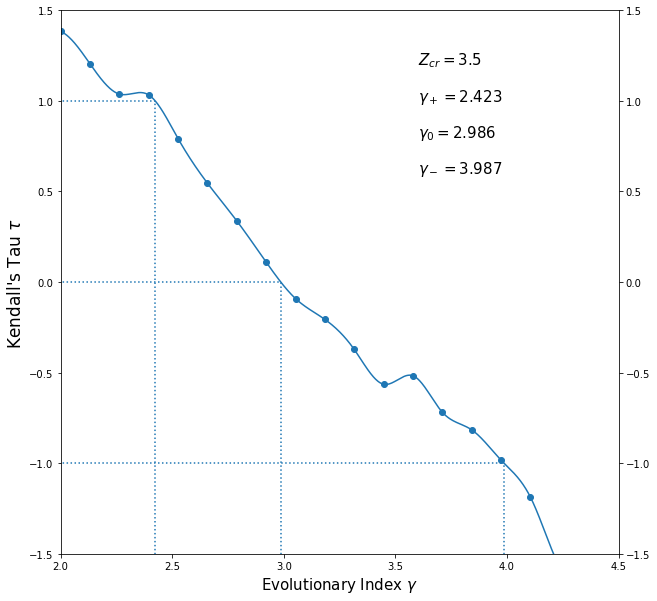

In [10]:
#### graph behavior of kendall's tau as function of gamma ####

def graph_kendall():
    fig, ax = plt.subplots(figsize=(10,10))

    plt.scatter(g_space, y)
    plt.plot(x_space, y_model)

    plt.hlines([1,0,-1], 0, [linestops[0], linestops[1], linestops[2]], linestyles='dotted')
    plt.vlines([linestops[0], linestops[1], linestops[2]], -2, [1, 0, -1], linestyles='dotted')

    text = [r'$\gamma_+ = ${}'.format(round(linestops[0], 3)),  r'$\gamma_0 = ${}'.format(round(linestops[1], 3)), 
            r'$\gamma_- = ${}'.format(round(linestops[2], 3))]

    for i in range(3): 
        ax.text(3.6, 1 - .2*i, text[i], fontsize=15)

    ax.text(3.6, 1.2, r'$Z_{cr} = 3.5$', fontsize=15)
    ax.set_ylim([-1.5, 1.5])
    ax.set_xlim([2, 4.5])

    ax.set_xlabel(r'Evolutionary Index $\gamma$', size=15)
    ax.set_ylabel(r"Kendall's Tau $\tau$", size=17)


    plt.tick_params(labelright=True, right=True)
    # plt.savefig('Tau Evolution-index Dependence Z_cr = 3.5.pdf' )
    plt.show()

graph_kendall()

In [ ]:
sfr = lambda x: x**2.7 / (1 + (x / 2.9)**5.6) # ansatz for star formation rate as function of redshift
    
#### time-integrate star formation rate 'sfr' ####

def sf(z, a=min(rs)):
    return quad(sfr, a + 1, (z + 1))[0]

In [ ]:
#### construct cumulative distributions ####

def z_cumulative(n, aset): # cumulative formation rate up to index n
    phi = 1
    start = np.argwhere(aset > 0).flatten()[0] # where to start the discrete integration
    for i in range(start, n):
        phi *= (1 + (1 / aset[i]))
    return phi     # ? restart at nonzero value if intermediate zero value appears?

def raw_cumulative(z, sorted_lst=rs):
    count = len(np.argwhere(sorted_lst < z))
    return count

# no lum evolution
vals_no_evo = []
for i in range(len(rs_trunc)):
    vals_no_evo.append(z_cumulative(i, x_assoc_sets))

# lum evolution with gamma = gamma_opt
min_lum_evo, lum_evo, evo_opt, rs_evo = truncate(min_lum, lum, (1 + rs)**gamma_opt)
x_ranks_evo, x_assoc_sets_evo = np.array(get_x_ranks(min_lum_evo, lum_evo, evo_opt))
vals_evo = []
for i in range(len(rs_evo)):
    vals_evo.append(z_cumulative(i, x_assoc_sets_evo))

# observed behavior
vals2 = []
for i in range(len(rs)):
    vals2.append(raw_cumulative(np.sort(rs)[i]))
    
vals3 = []
for i in range(len(rs)):
    vals3.append(z_cumulative(i, np.array(vals2)))

In [ ]:
def graph_cumulative_formation_rates():

    # superpose cumulative rates graphically

    fig, ax = plt.subplots(figsize=(14, 10)) 

    ax.scatter(np.sort(rs_trunc) + 1, vals_no_evo, marker='x', s=16, c='k', 
               label=r'Trunc. CHIME, No Evolution') 
    ax.scatter(np.sort(rs_evo) + 1, vals_evo, marker='s', s=16, c='w', 
               label=r"Trunc. CHIME, Evolution $E' = \frac{E}{g(z)}$")
    ax.scatter(np.sort(rs) + 1, vals2, marker='o', alpha=1, s=16, c='c', 
            label=r"CHIME, Observed $N(Z' < Z)$")
    ax.plot(np.sort(rs) + 1.04, 10**6.3*sfr(np.sort(rs)), linestyle='-', c='r', 
            label=r'(Scaled) Time-Integrated SFR, Madau and Dickinson 2015')

    # ax.vlines(x_cr, 1, 10**7, colors='m', linestyles='dotted', label='$Z_{cr} = 3.5$')

    ax.vlines([1,2,3,4], 0.5, 1e9, colors='k', alpha=.18, linestyles='dotted')
    ax.hlines([1e1,1e2,1e3,1e4,1e5,1e6,1e7,1e8], 0, 5, colors='k', alpha=.18, linestyles='dotted')


    ax.text(.96, 10**5.8, r'$g(z < z_{cr}) = Z^{\gamma_0}$', c='w', fontsize=16)
    ax.text(.96, 10**5.4,
            r'$g(z \geq z_{cr}) = Z^{\gamma_0}\frac{1 + Z_{cr}^{\gamma_0}}{Z^{\gamma_0} + Z_{cr}^{\gamma_0}}$',
            c='w',fontsize=16)
    ax.text(.96, 10**6.2, r'$Z_{cr}=3.5$', c='w', fontsize=16)
    ax.text(2.75, 10**3.1, 'CHIME FRB Cumulative', c='c', fontsize=16)
    ax.text(2.8, 10**6.25, 'EP w/ Evolution', c='w', fontsize=16)
    ax.text(3.1, 10**7.35, 'Star Formation', c='r', fontsize=16)
    ax.text(3.25, 10**8.05, 'EP w/o Evolution', c='k', fontsize=15)

    ax.set_yscale('log', base=10)
    ax.set_xscale('log', base=10)
    ax.set_xlabel(r'Redshift Z = 1+z', size=15)
    ax.set_ylabel(r'Cumulative FRB Density Evolution $\sigma(z)$', size=15)
    ax.set_xlim(.9, 4.2)
    ax.set_ylim(0.5, 10**8.5)
    ax.set_facecolor('gray')

    plt.tick_params(labelright=True, right=True)
    plt.legend(fontsize=14, loc='best')
    #plt.savefig('CHIME Cumulative Density Comparisons Z_cr=3.5.png')
    plt.show()

In [ ]:
graph_cumulative_formation_rates()

In [ ]:
#### Considerations for continuing study: ####

# plot raw log(N) v. log(rs+1)

# K correct using sample FRB spectrum ? 

# SFR: A*Z^2.7 / (1+(Z/2.9)^5.6) integrate from Z = 1 to Z_max   ? normalize Z = 1.5 to 2 ?

# fit using broken power law

# raw log cumulative energy function